# Using Deep Neural Network for Regression Analysis
 

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/cern-electron-collision-data/dielectron.csv


# Dataset

A look at the dataset-

In [2]:
data = pd.read_csv("/kaggle/input/cern-electron-collision-data/dielectron.csv")
data.head()

,Run,Event,E1,px1,py1,pz1,pt1,eta1,phi1,Q1,E2,px2,py2,pz2,pt2,eta2,phi2,Q2,M
0,147115,366639895,58.71410,-7.31132,10.531000,-57.29740,12.82020,-2.20267,2.17766,1,11.2836,-1.032340,-1.88066,-11.0778,2.14537,-2.344030,-2.072810,-1,8.94841
1,147115,366704169,6.61188,-4.15213,-0.579855,-5.11278,4.19242,-1.02842,-3.00284,-1,17.1492,-11.713500,5.04474,11.4647,12.75360,0.808077,2.734920,1,15.89300
2,147115,367112316,25.54190,-11.48090,2.041680,22.72460,11.66100,1.42048,2.96560,1,15.8203,-1.472800,2.25895,-15.5888,2.69667,-2.455080,2.148570,1,38.38770
3,147115,366952149,65.39590,7.51214,11.887100,63.86620,14.06190,2.21838,1.00721,1,25.1273,4.087860,2.59641,24.6563,4.84272,2.330210,0.565865,-1,3.72862
4,147115,366523212,61.45040,2.95284,-14.622700,-59.61210,14.91790,-2.09375,-1.37154,-1,13.8871,-0.277757,-2.42560,-13.6708,2.44145,-2.423700,-1.684810,-1,2.74718


# Preprocessing -

We can disregard variables used for identification. The input is then normalized, while the output is rescaled to a logarithmic scale:

In [3]:
s_data = data.drop(["Run", "Event"], axis = 1).dropna()
Xn_data = np.array(s_data.drop(["M"], axis = 1))
# Normalize X_data
X_data = (Xn_data - np.mean(Xn_data)) / np.std(Xn_data)
y_data = np.log(np.array(s_data["M"]))

In [4]:
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split

Splitting the training, validation and test sets:

In [5]:
train_X, dev_test_X, train_y, dev_test_y = train_test_split(X_data, y_data, test_size = 0.2, random_state = 20) 
dev_X, test_X, dev_y, test_y = train_test_split(dev_test_X, dev_test_y, test_size = 0.5, random_state = 21)

Custon Metric for $R^{2}$

source: https://stackoverflow.com/questions/45250100/kerasregressor-coefficient-of-determination-r2-score

In [6]:
def r2_score(y_true, y_pred):
    from keras import backend as K
    SS_res =  K.sum(K.square( y_true-y_pred ))
    SS_tot = K.sum(K.square( y_true - K.mean(y_true) ) )
    return ( 1 - SS_res/(SS_tot + K.epsilon()) )

# Framework for Deep Neural Network

In [7]:
from tensorflow.keras import regularizers
# Neural Network Design
model = keras.Sequential([
    layers.Dense(128, activation = 'relu', input_shape = [16]),
    layers.Dense(64, activation = 'relu'),
    layers.Dense(32, activation = 'relu'),
    layers.Dense(16, activation = 'relu'),
    layers.Dense(1)
])

model.compile(optimizer = 'Adam', loss = 'mse', metrics = [r2_score])


# Callback

A callback to store the model parameters with the best performance:

In [8]:
model_callback = keras.callbacks.ModelCheckpoint(
    filepath = "/tmp/checkpoint",
    monitor="val_loss",
    verbose=0,
    save_best_only=True,
    save_weights_only=True,
    mode="auto",
    save_freq="epoch",
    options=None,
)

In [9]:
history = model.fit(train_X, train_y, batch_size = 512, epochs = 300, validation_data = (dev_X, dev_y), callbacks = [model_callback])

Epoch 1/300
157/157 [==============================] - 2s 7ms/step - loss: 3.9809 - r2_score: -3.9181 - val_loss: 0.4023 - val_r2_score: 0.5113
Epoch 2/300
157/157 [==============================] - 1s 4ms/step - loss: 0.3388 - r2_score: 0.5840 - val_loss: 0.2436 - val_r2_score: 0.7048
Epoch 3/300
157/157 [==============================] - 1s 4ms/step - loss: 0.2208 - r2_score: 0.7294 - val_loss: 0.1649 - val_r2_score: 0.8003
Epoch 4/300
157/157 [==============================] - 1s 3ms/step - loss: 0.1403 - r2_score: 0.8264 - val_loss: 0.1249 - val_r2_score: 0.8488
Epoch 5/300
157/157 [==============================] - 1s 3ms/step - loss: 0.0978 - r2_score: 0.8790 - val_loss: 0.0971 - val_r2_score: 0.8820
Epoch 6/300
157/157 [==============================] - 1s 3ms/step - loss: 0.0736 - r2_score: 0.9080 - val_loss: 0.0589 - val_r2_score: 0.9286
Epoch 7/300
157/157 [==============================] - 1s 3ms/step - loss: 0.0561 - r2_score: 0.9304 - val_loss: 0.0638 - val_r2_score: 0.922

<function matplotlib.pyplot.axis(*args, emit=True, **kwargs)>

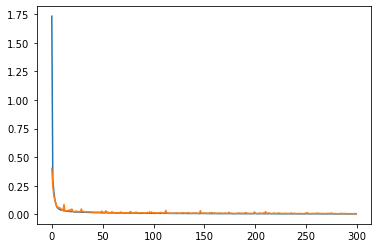

In [10]:
# Plot loss of output
from matplotlib import pyplot as plt
plt.plot(history.history['loss'], label = "")
plt.plot(history.history['val_loss'])
plt.axis

In [11]:
model.load_weights("/tmp/checkpoint")

# Performance on the test set:

Estimates for (MSE, $R^{2}$ score)

In [12]:
model.test_on_batch(dev_X, dev_y)

[0.005287243518978357, 0.9933468103408813]